# Project 2: Carry

By: Chengyi (Jeff) Chen

Description of The Project:

We want to build a commodity curve strategy by trading WTI futures. The commodity curve strategy takes a long position of an optimally-chosen contract and a short position of another contract at any time in order to capture the commodity's term struture premium.

Here are the steps for portfolio construction and rebalancing:

- Step 1: At each month-end date, we consider contracts on tenors from T2 to T12. (T1 contract would not be considered since it has less than 1 month to expiration)

- Step 2A: For each tenor contract, calculate the expected rolling return if holding the contract for one month based on the current term structure.  (Let's assume the expiration dates of two adjacent contracts are always exactly one-month away).

- Step 2B: Among the 11 contracts (from T2 to T12), build a portfolio with one long position in the contract with the highest expected rolling return, and one short position in the contract with the lowest expected rolling return.

- Step 3: Hold the portfolio till the next month-end and rebalance the portfolio.

You need to run the back-test for the strategy from 1/31/2000 to 1/31/2019, calculate the strategy's monthly returns, and deliver the following results:

1. Assume we invest \\$1 in the strategy from day 1, i.e., 1/31/2000, please plot the value of our investment over time.

2. Calculate the strategy's calendar year returns, i.e., cumulative returns in each year from 2000 to 2019.

3. Calculate the annualized return, annualized risk, and Sharpe ratio (let's assume risk-free rate of 0) of the strategy.

4. Identify the maximum drawdown period for this strategy.

In [1]:
%load_ext autotime
%load_ext nb_black
%matplotlib inline

import matplotlib.pyplot as plt

# from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (10, 8)

from collections import defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
import scipy as sp
import plotly.express as px
import plotly.graph_objects as go

<IPython.core.display.Javascript object>

### Data

In [2]:
raw_data = pd.read_excel("./data/Project2_WTI_OilCurve.XLSX", sheet_name=1, header=None)


def format_commodity_prices(df):
    new_df = df.iloc[2:, 1:4]
    new_df.columns = df.iloc[1, 1:4].values
    new_df.index = df.iloc[2:, 0].values
    return new_df


commodity_data = pd.concat(
    [
        format_commodity_prices(raw_data.iloc[:, start:stop])
        for start, stop in zip(
            list(range(0, raw_data.shape[1] + 1, 6)),
            list(range(5, raw_data.shape[1] + 1, 6)),
        )
    ],
    axis=1,
    keys=[f"Term {idx+1}" for idx in range(12)],
)

commodity_data.index = pd.to_datetime(commodity_data.index)
commodity_data.head()

Term 1                             Term 2          \
           FUT_CUR_GEN_TICKER PX LAST  VOLUME FUT_CUR_GEN_TICKER PX LAST   
2000-01-31              CLH00   27.64   83938              CLJ00   26.72   
2000-02-01              CLH00   28.22   80801              CLJ00   27.26   
2000-02-02              CLH00   27.55  100243              CLJ00   26.67   
2000-02-03              CLH00   28.03   80492              CLJ00   27.13   
2000-02-04              CLH00   28.82   67793              CLJ00   27.82   

                              Term 3                            Term 4  ...  \
           VOLUME FUT_CUR_GEN_TICKER PX LAST VOLUME FUT_CUR_GEN_TICKER  ...   
2000-01-31  30986              CLK00   25.97   6006              CLM00  ...   
2000-02-01  33388              CLK00   26.49   7648              CLM00  ...   
2000-02-02  50618              CLK00   25.96   9423              CLM00  ...   
2000-02-03  38659              CLK00   26.39  11135              CLM00  ...   
2000-02-04  27438              CLK00   27.04   9120              CLM00  ...   

           Term 9            Term 10                           Term 11  \
           VOLUME FUT_CUR_GEN_TICKER PX LAST VOLUME FUT_CUR_GEN_TICKER   
2000-01-31    781              CLZ00   22.49   5380              CLF01   
2000-02-01    718              CLZ00   22.84   8690              CLF01   
2000-02-02    716              CLZ00   22.55   5921              CLF01   
2000-02-03   4071              CLZ00   22.95   3372              CLF01   
2000-02-04    197              CLZ00   23.41   3458              CLF01   

                                     Term 12                 
           PX LAST VOLUME FUT_CUR_GEN_TICKER PX LAST VOLUME  
2000-01-31   22.14   1354              CLG01   21.81    848  
2000-02-01   22.47   1354              CLG01   22.12    580  
2000-02-02   22.18    771              CLG01   21.83     28  
2000-02-03   22.57   3856              CLG01   22.21    225  
2000-02-04   23.03    281              CLG01   22.67    106  

[5 rows x 36 columns]

time: 2.6 s


<IPython.core.display.Javascript object>

### Step 1: At each month-end date, we consider contracts on tenors from T2 to T12. (T1 contract would not be considered since it has less than 1 month to expiration)

In [3]:
contracts_of_interest = commodity_data[commodity_data.index.is_month_end].loc[
    :, [(f"Term {idx}", "PX LAST") for idx in range(1, 13)]
]
contracts_of_interest.head()

Term 1  Term 2  Term 3  Term 4  Term 5  Term 6  Term 7  Term 8  \
           PX LAST PX LAST PX LAST PX LAST PX LAST PX LAST PX LAST PX LAST   
2000-01-31   27.64   26.72   25.97   25.32   24.71   24.17   23.71   23.27   
2000-02-29   30.43   28.85   27.68   26.74      26   25.35   24.79   24.32   
2000-03-31    26.9   26.38   26.04   25.76   25.48   25.19    24.9    24.6   
2000-05-31   29.01   28.42   27.89    27.4   26.92   26.47   26.06   25.69   
2000-06-30    32.5   31.13    30.2   29.51   28.94   28.42   27.92   27.45   

            Term 9 Term 10 Term 11 Term 12  
           PX LAST PX LAST PX LAST PX LAST  
2000-01-31   22.87   22.49   22.14   21.81  
2000-02-29   23.88   23.44   23.04   22.65  
2000-03-31   24.28   23.97   23.68   23.39  
2000-05-31   25.32   24.95   24.58   24.21  
2000-06-30   27.02   26.61   26.23   25.87

time: 21.7 ms


<IPython.core.display.Javascript object>

In [4]:
unstacked_price = (
    (
        commodity_data[commodity_data.index.is_month_end].loc[
            :, [(f"Term {idx}", "PX LAST") for idx in range(1, 13)]
        ]
    )
    .unstack()
    .reset_index()
    .drop(["level_1"], axis=1)
)

unstacked_volume = (
    (
        commodity_data[commodity_data.index.is_month_end].loc[
            :, [(f"Term {idx}", "VOLUME") for idx in range(1, 13)]
        ]
    )
    .unstack()
    .reset_index()
    .drop(["level_1"], axis=1)
)

unstacked = pd.merge(unstacked_price, unstacked_volume, on=["level_0", "level_2"])
unstacked.columns = ["term", "date", "price", "volume"]
unstacked["price"] = unstacked["price"].astype(float)
unstacked["volume"] = unstacked["volume"].astype(int)
unstacked["term"] = unstacked["term"].apply(
    lambda x: int(x.lower().replace("term ", ""))
)
unstacked["date"] = unstacked["date"].astype(str)
fig = px.scatter(
    data_frame=unstacked,
    x="term",
    y="price",
    size="volume",
    animation_frame="date",
    range_x=[0, 13],
    range_y=[unstacked["price"].min(), unstacked["price"].max()],
    title="Futures Curve for WTI",
)
fig.show()

time: 5.94 s


<IPython.core.display.Javascript object>

### Step 2A: For each tenor contract, calculate the expected rolling return if holding the contract for one month based on the current term structure. (Let's assume the expiration dates of two adjacent contracts are always exactly one-month away).

In [5]:
expected_rolling_return_assume_current_term_structure = (
    contracts_of_interest.pct_change(periods=-1, axis=1).shift(1, axis=1).dropna(axis=1)
)
expected_rolling_return_assume_current_term_structure.head()

Term 2    Term 3    Term 4    Term 5    Term 6    Term 7  \
             PX LAST   PX LAST   PX LAST   PX LAST   PX LAST   PX LAST   
2000-01-31  0.034431  0.028879  0.025671  0.024686  0.022342  0.019401   
2000-02-29  0.054766  0.042269  0.035153  0.028462  0.025641  0.022590   
2000-03-31  0.019712  0.013057  0.010870  0.010989  0.011513  0.011647   
2000-05-31  0.020760  0.019003  0.017883  0.017831  0.017000  0.015733   
2000-06-30  0.044009  0.030795  0.023382  0.019696  0.018297  0.017908   

              Term 8    Term 9   Term 10   Term 11   Term 12  
             PX LAST   PX LAST   PX LAST   PX LAST   PX LAST  
2000-01-31  0.018908  0.017490  0.016896  0.015808  0.015131  
2000-02-29  0.019326  0.018425  0.018771  0.017361  0.017219  
2000-03-31  0.012195  0.013180  0.012933  0.012247  0.012398  
2000-05-31  0.014402  0.014613  0.014830  0.015053  0.015283  
2000-06-30  0.017122  0.015914  0.015408  0.014487  0.013916

time: 42.1 ms


<IPython.core.display.Javascript object>

### Step 2B: Among the 11 contracts (from T2 to T12), build a portfolio with one long position in the contract with the highest expected rolling return, and one short position in the contract with the lowest expected rolling return.

In [6]:
# actual_returns = contracts_of_interest.pct_change().shift(-1).dropna()
longs = expected_rolling_return_assume_current_term_structure.idxmax(axis=1)
# longs = longs.to_frame().reset_index()
# longs.columns = ["date", "term"]
shorts = expected_rolling_return_assume_current_term_structure.idxmin(axis=1)
# shorts.to_frame().reset_index()
# shorts.columns = ["date", "term"]

time: 11.5 ms


<IPython.core.display.Javascript object>

### Step 3: Hold the portfolio till the next month-end and rebalance the portfolio.

In [7]:
longs_buy_price = (
    longs.reset_index()
    .rename({"index": "date", 0: "term"}, axis=1)
    .apply(lambda row: contracts_of_interest.loc[row["date"], row["term"]], axis=1)[:-1]
)  # Exclude last buy price since we can't observe how much the next month sell price is

longs_sell_price = (
    longs.shift(1)
    .dropna()
    .reset_index()
    .rename({"index": "date", 0: "term"}, axis=1)
    .apply(
        lambda row: contracts_of_interest.loc[
            row["date"],
            ("Term " + str(int(row["term"][0].split(" ")[1]) - 1), row["term"][1]),
        ],  # Get the contract price @ term = t - 1 month
        axis=1,
    )
)

longs_returns = (longs_sell_price / longs_buy_price) - 1
longs_returns.index = longs.index[1:]
longs_returns

2000-02-29    0.138847
2000-03-31   -0.067591
2000-05-31    0.099697
2000-06-30    0.143561
2000-07-31   -0.118856
                ...   
2018-08-31    0.032086
2018-10-31   -0.058527
2018-11-30   -0.210238
2018-12-31   -0.069830
2019-01-31    0.130722
Length: 164, dtype: float64

time: 116 ms


<IPython.core.display.Javascript object>

In [8]:
shorts_buy_price = (
    shorts.reset_index()
    .rename({"index": "date", 0: "term"}, axis=1)
    .apply(lambda row: contracts_of_interest.loc[row["date"], row["term"]], axis=1)[:-1]
)  # Exclude last buy price since we can't observe how much the next month sell price is

shorts_sell_price = (
    shorts.shift(1)
    .dropna()
    .reset_index()
    .rename({"index": "date", 0: "term"}, axis=1)
    .apply(
        lambda row: contracts_of_interest.loc[
            row["date"],
            ("Term " + str(int(row["term"][0].split(" ")[1]) - 1), row["term"][1]),
        ],  # Get the contract price @ term = t - 1 month
        axis=1,
    )
)

shorts_returns = 1 - (shorts_sell_price / shorts_buy_price)
shorts_returns.index = shorts.index[1:]
shorts_returns

2000-02-29   -0.056396
2000-03-31   -0.045475
2000-05-31   -0.082686
2000-06-30   -0.086804
2000-07-31    0.017395
                ...   
2018-08-31   -0.031180
2018-10-31    0.046664
2018-11-30    0.220599
2018-12-31    0.111176
2019-01-31   -0.167706
Length: 164, dtype: float64

time: 93.7 ms


<IPython.core.display.Javascript object>

In [9]:
monthly_strategy_returns = pd.concat(
    [longs_returns, shorts_returns], keys=["longs", "shorts"], axis=1
)
monthly_strategy_returns

longs    shorts
2000-02-29  0.138847 -0.056396
2000-03-31 -0.067591 -0.045475
2000-05-31  0.099697 -0.082686
2000-06-30  0.143561 -0.086804
2000-07-31 -0.118856  0.017395
...              ...       ...
2018-08-31  0.032086 -0.031180
2018-10-31 -0.058527  0.046664
2018-11-30 -0.210238  0.220599
2018-12-31 -0.069830  0.111176
2019-01-31  0.130722 -0.167706

[164 rows x 2 columns]

time: 6.88 ms


<IPython.core.display.Javascript object>

In [10]:
portfolio_returns = (
    monthly_strategy_returns.sum(axis=1)
    .to_frame()
    .rename({0: "monthly_returns"}, axis=1)
)
portfolio_returns.head()

monthly_returns
2000-02-29         0.082451
2000-03-31        -0.113066
2000-05-31         0.017010
2000-06-30         0.056757
2000-07-31        -0.101462

time: 4.98 ms


<IPython.core.display.Javascript object>

You need to run the back-test for the strategy from 1/31/2000 to 1/31/2019, calculate the strategy's monthly returns, and deliver the following results:

1. Assume we invest \\$1 in the strategy from day 1, i.e., 1/31/2000, please plot the value of our investment over time.

2. Calculate the strategy's calendar year returns, i.e., cumulative returns in each year from 2000 to 2019.

3. Calculate the annualized return, annualized risk, and Sharpe ratio (let's assume risk-free rate of 0) of the strategy.

4. Identify the maximum drawdown period for this strategy.

### 1. Assume we invest \\$1 in the strategy from day 1, i.e., 1/31/2000, please plot the value of our investment over time.

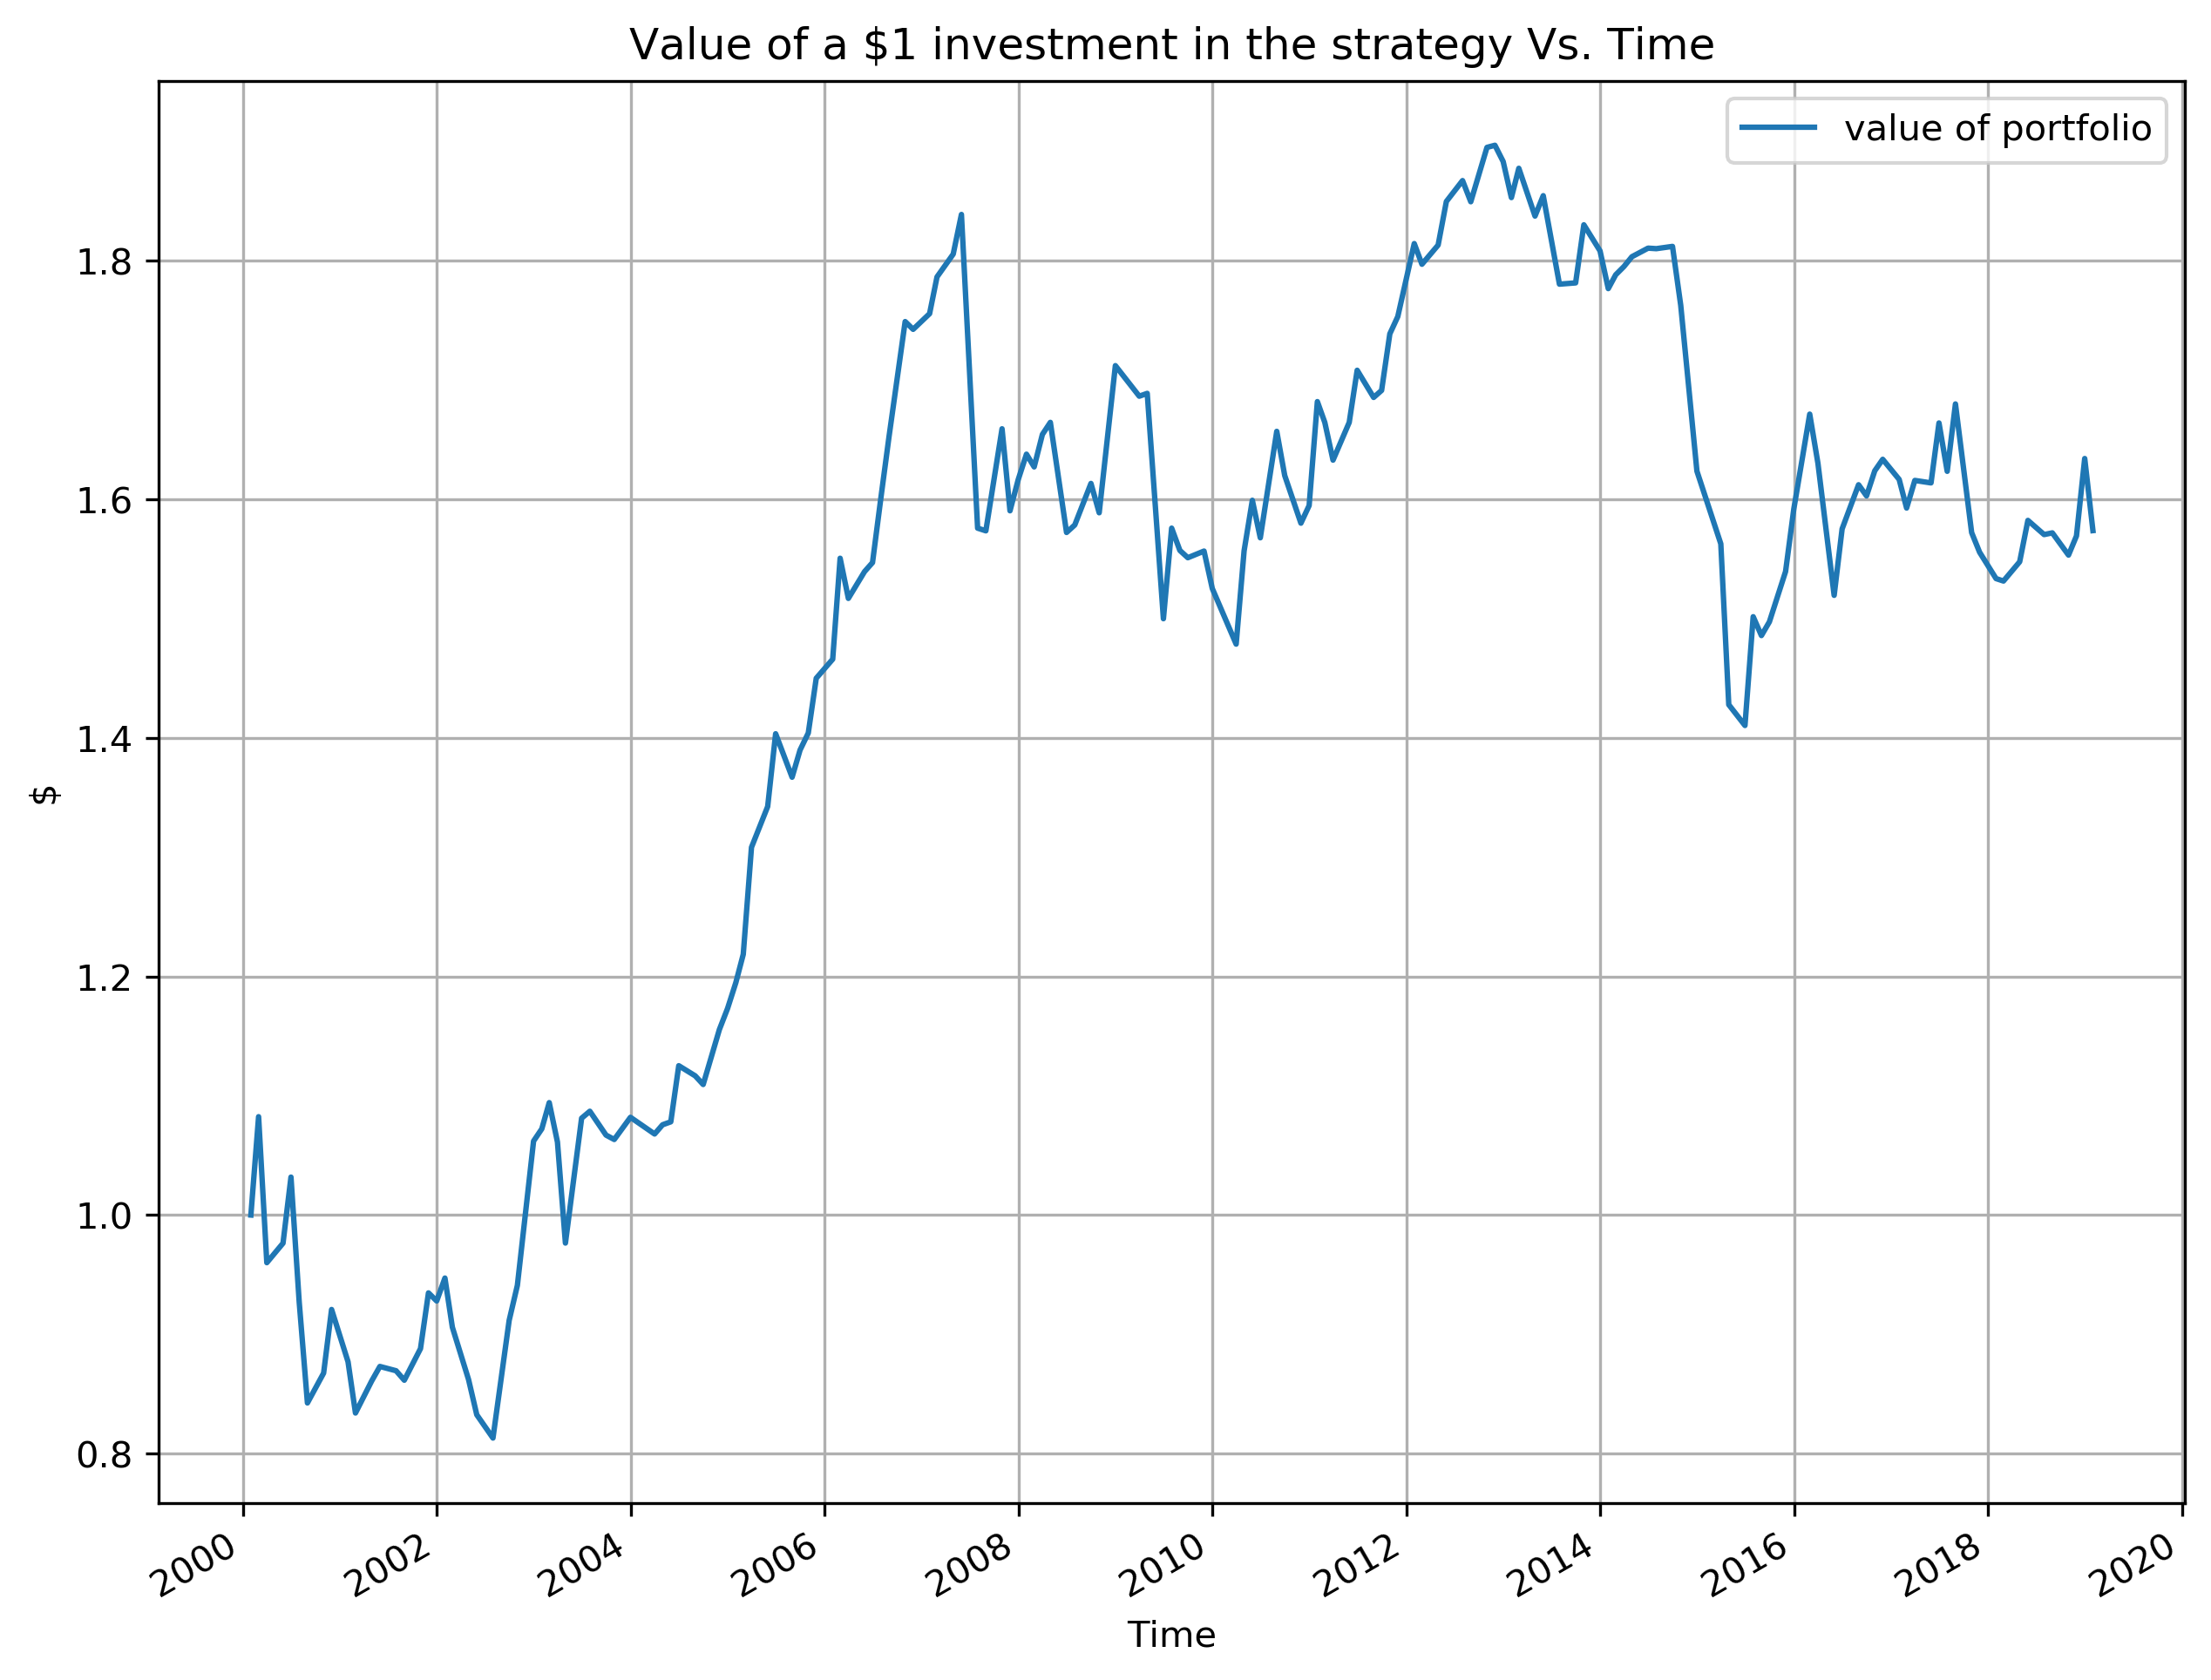

time: 637 ms


<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(1, 1)
portfolio_value = pd.concat(
    [
        pd.DataFrame({"monthly_returns": 1}, index=[contracts_of_interest.index[0]]),
        (portfolio_returns + 1).cumprod(),
    ],
    axis=0,
).rename({"monthly_returns": "value of portfolio"}, axis=1)
portfolio_value.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("$")
ax.set_title("Value of a $1 investment in the strategy Vs. Time")
plt.legend()
plt.grid(True)
plt.show()

### 2. Calculate the strategy's calendar year returns, i.e., cumulative returns in each year from 2000 to 2019.

In [12]:
portfolio_returns["year"] = portfolio_returns.index.year
portfolio_returns.groupby(by="year")["monthly_returns"].apply(
    lambda returns: np.prod(1 + returns) ** (12 / len(returns)) - 1
).to_frame().rename({"monthly_returns": "calendar_year_returns"}, axis=1)

calendar_year_returns
year                       
2000              -0.116355
2001               0.010307
2002               0.224335
2003               0.025101
2004               0.129248
2005               0.326277
2006               0.277612
2007              -0.095152
2008               0.079514
2009              -0.159074
2010               0.069080
2011               0.134606
2012               0.100032
2013              -0.059064
2014              -0.133769
2015              -0.029211
2016               0.039544
2017              -0.063074
2018               0.067895
2019              -0.363789

time: 14.2 ms


<IPython.core.display.Javascript object>

### 3. Calculate the annualized return, annualized risk, and Sharpe ratio (let's assume risk-free rate of 0) of the strategy.

In [13]:
annualized_return = (portfolio_returns["monthly_returns"] + 1).prod() ** (
    12 / len(portfolio_returns["monthly_returns"])
) - 1
print(
    f"Annualized Return:", np.round(annualized_return, 4,),
)

annualized_volatility = portfolio_returns["monthly_returns"].std() * np.sqrt(12)
print(
    f"Annualized Risk:", np.round(annualized_volatility, 4,),
)

sharpe_ratio = annualized_return / annualized_volatility
print(
    f"Sharpe Ratio (with r_f = 0):", np.round(sharpe_ratio, 4),
)

Annualized Return: 0.0337
Annualized Risk: 0.1371
Sharpe Ratio (with r_f = 0): 0.246
time: 1.85 ms


<IPython.core.display.Javascript object>

### 4. Identify the maximum drawdown period for this strategy.

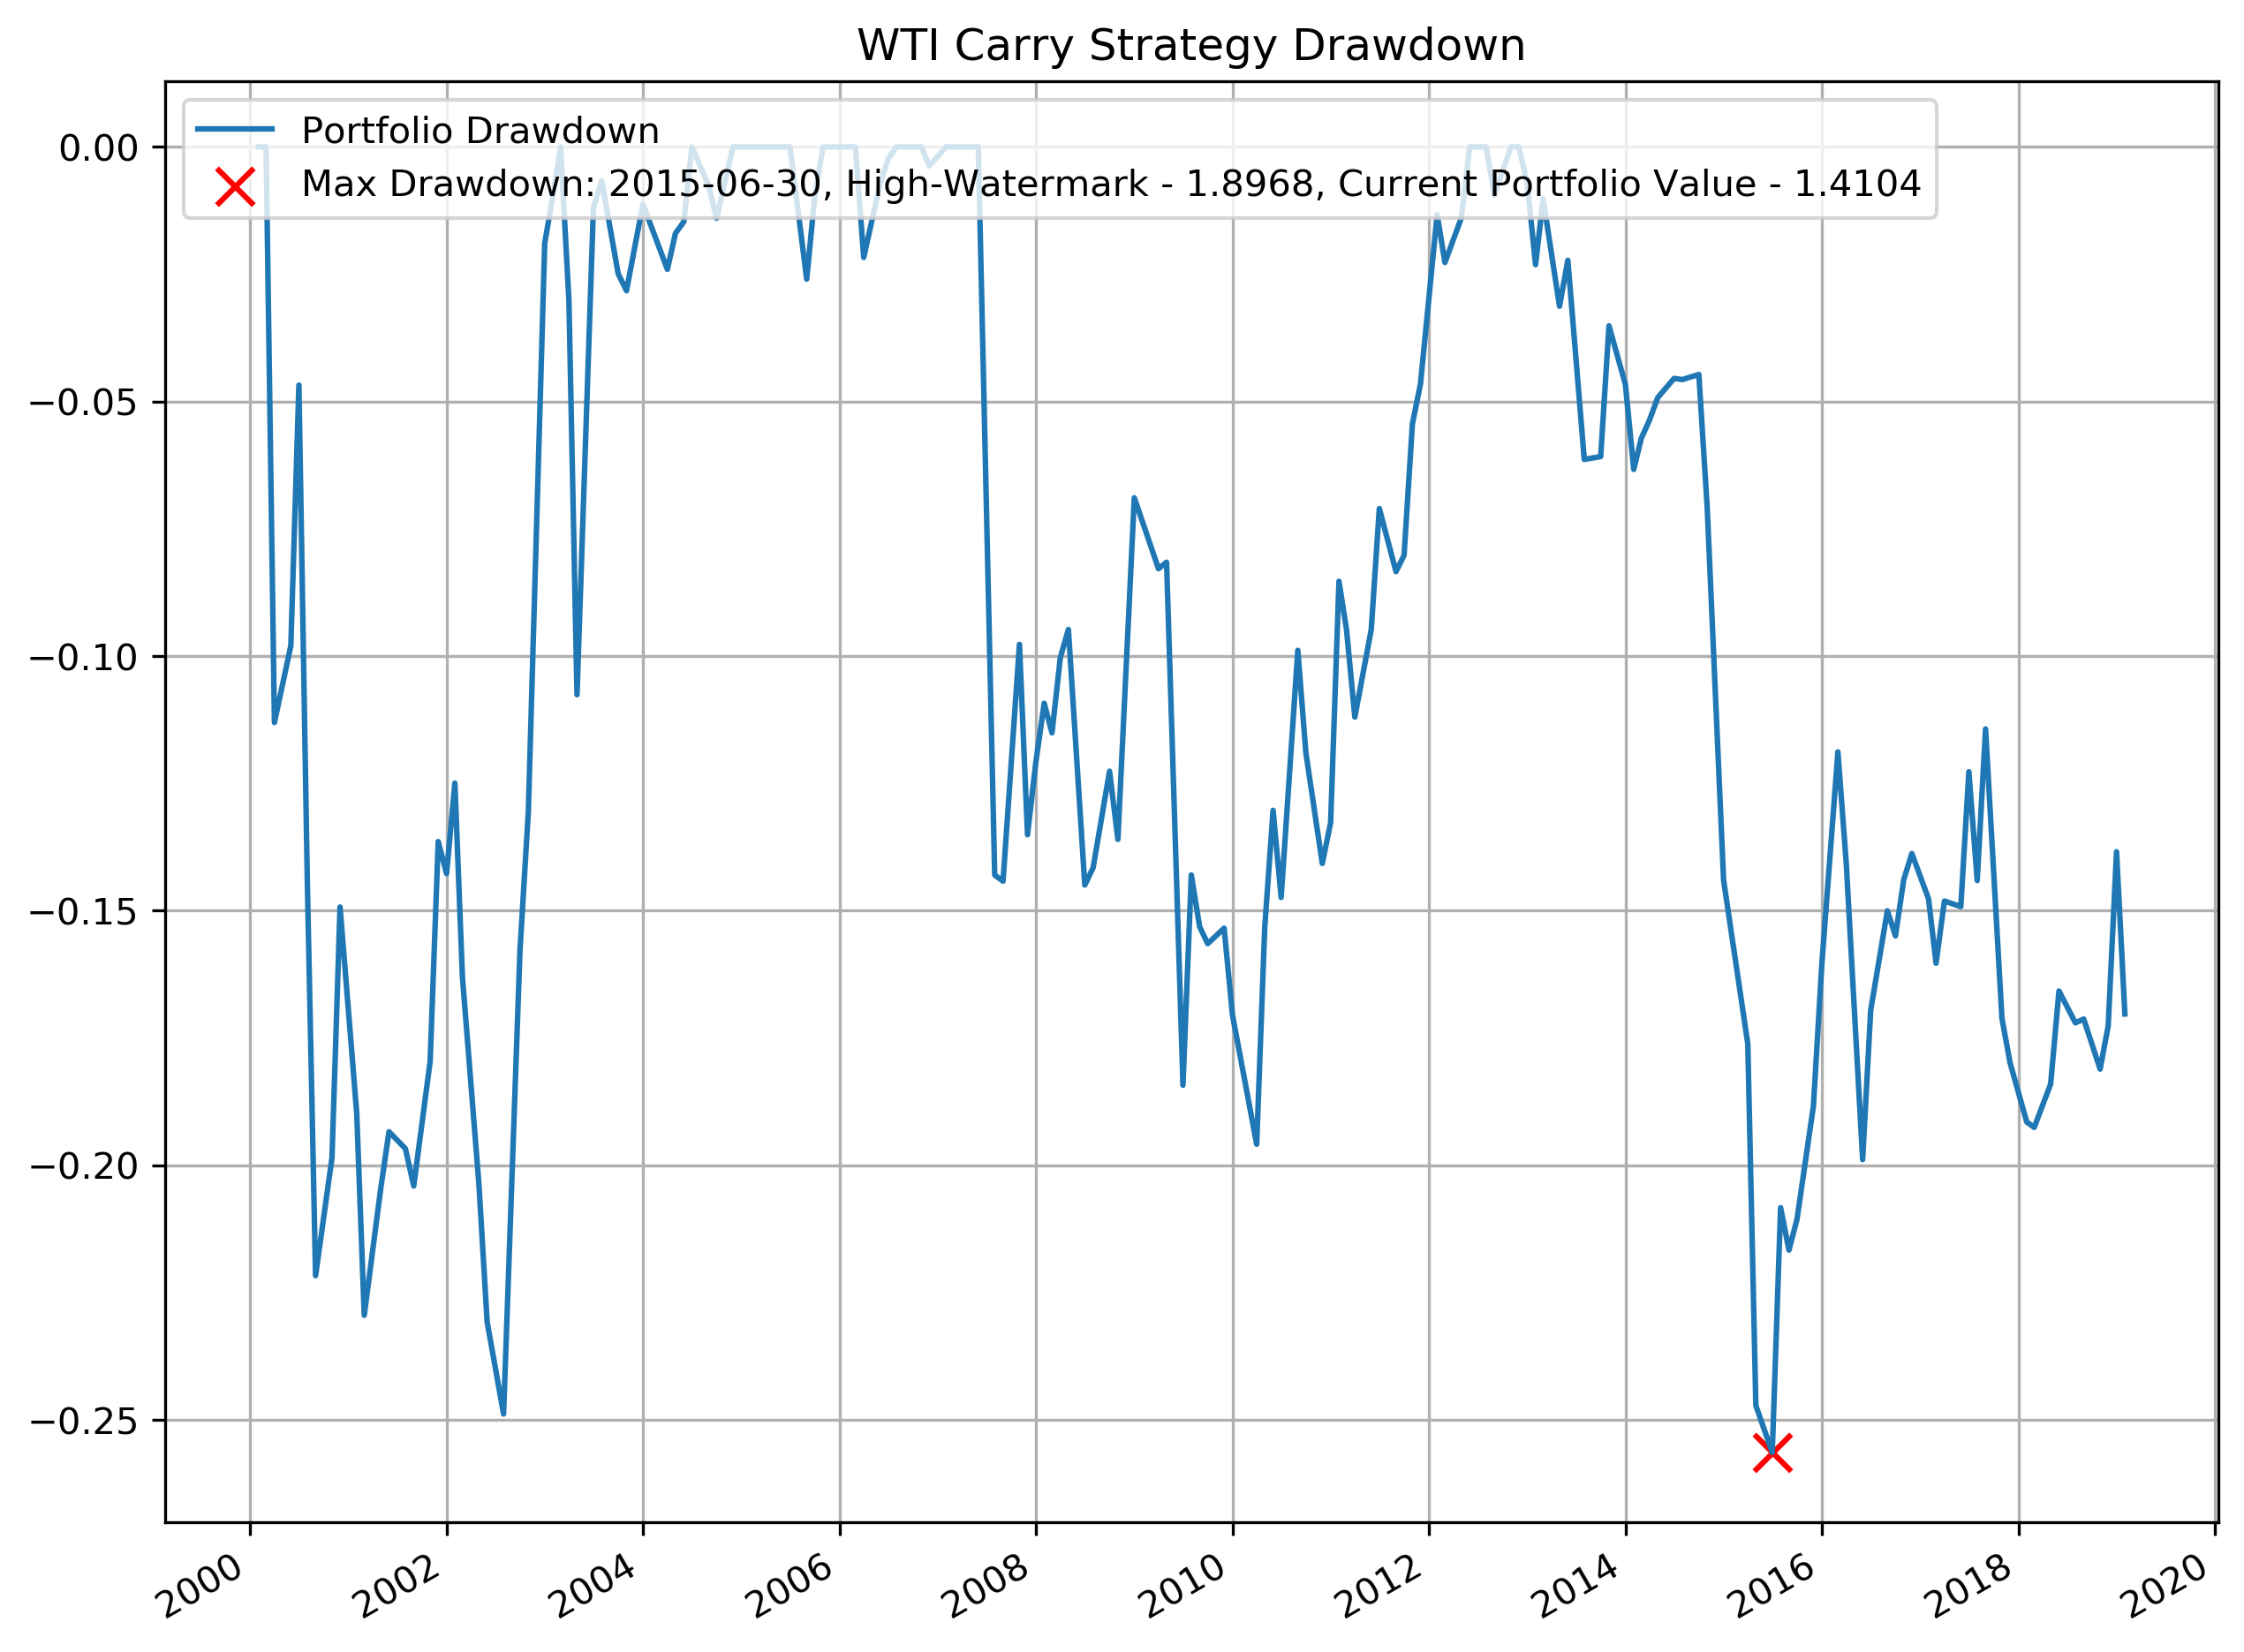

time: 745 ms


<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(1, 1)

portfolio_highwatermark = np.maximum.accumulate(portfolio_value)
portfolio_drawdown = (portfolio_value / portfolio_highwatermark - 1).rename(
    {"value of portfolio": "Portfolio Drawdown"}, axis=1
)
portfolio_drawdown.plot.line(ax=ax)
ax.scatter(
    portfolio_drawdown.idxmin(),
    portfolio_drawdown.min(),
    s=100,
    c="red",
    marker="x",
    label=f"Max Drawdown: {pd.to_datetime(str(portfolio_drawdown.idxmin().values[0])).strftime('%Y-%m-%d')}, High-Watermark - {np.round(portfolio_highwatermark.loc[portfolio_drawdown.idxmin()].values[0][0], 4)}, Current Portfolio Value - {np.round(portfolio_value.loc[portfolio_drawdown.idxmin()].values[0][0], 4)}",
)
ax.set_title("WTI Carry Strategy Drawdown")
ax.legend(loc=2)
ax.grid(True)